# Създайте модел за класификация: Вкусни азиатски и индийски ястия


## Класификатори на кухни 1

В този урок ще разгледаме разнообразие от класификатори, за да *предвидим дадена национална кухня въз основа на група съставки.* Докато правим това, ще научим повече за някои от начините, по които алгоритмите могат да бъдат използвани за задачи по класификация.

### [**Тест преди лекцията**](https://gray-sand-07a10f403.1.azurestaticapps.net/quiz/21/)

### **Подготовка**

Този урок надгражда нашия [предишен урок](https://github.com/microsoft/ML-For-Beginners/blob/main/4-Classification/1-Introduction/solution/lesson_10-R.ipynb), където:

-   Направихме леко въведение в класификациите, използвайки набор от данни за всички невероятни кухни на Азия и Индия 😋.

-   Разгледахме някои [глаголи на dplyr](https://dplyr.tidyverse.org/), за да подготвим и почистим нашите данни.

-   Създадохме красиви визуализации с помощта на ggplot2.

-   Демонстрирахме как да се справяме с небалансирани данни, като ги предварително обработим с [recipes](https://recipes.tidymodels.org/articles/Simple_Example.html).

-   Показахме как да `prep` и `bake` нашата рецепта, за да потвърдим, че ще работи както трябва.

#### **Предварителни изисквания**

За този урок ще ни трябват следните пакети, за да почистим, подготвим и визуализираме нашите данни:

-   `tidyverse`: [tidyverse](https://www.tidyverse.org/) е [колекция от пакети за R](https://www.tidyverse.org/packages), създадена да направи науката за данни по-бърза, лесна и забавна!

-   `tidymodels`: [tidymodels](https://www.tidymodels.org/) е рамка, представляваща [колекция от пакети](https://www.tidymodels.org/packages/) за моделиране и машинно обучение.

-   `themis`: [themis](https://themis.tidymodels.org/) предоставя допълнителни стъпки за рецепти за справяне с небалансирани данни.

-   `nnet`: [nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf) предоставя функции за оценка на невронни мрежи с едно скрито ниво и за модели на мултиномиална логистична регресия.

Можете да ги инсталирате така:


`install.packages(c("tidyverse", "tidymodels", "DataExplorer", "here"))`

Алтернативно, скриптът по-долу проверява дали разполагате с необходимите пакети за завършване на този модул и ги инсталира, ако липсват.


In [2]:
suppressWarnings(if (!require("pacman"))install.packages("pacman"))

pacman::p_load(tidyverse, tidymodels, themis, here)

Loading required package: pacman



## 1. Разделете данните на тренировъчен и тестов набор.

Ще започнем, като изберем няколко стъпки от предишния урок.

### Премахнете най-често срещаните съставки, които създават объркване между различни кухни, използвайки `dplyr::select()`.

Всички обичат ориз, чесън и джинджифил!


In [3]:
# Load the original cuisines data
df <- read_csv(file = "https://raw.githubusercontent.com/microsoft/ML-For-Beginners/main/4-Classification/data/cuisines.csv")

# Drop id column, rice, garlic and ginger from our original data set
df_select <- df %>% 
  select(-c(1, rice, garlic, ginger)) %>%
  # Encode cuisine column as categorical
  mutate(cuisine = factor(cuisine))

# Display new data set
df_select %>% 
  slice_head(n = 5)

# Display distribution of cuisines
df_select %>% 
  count(cuisine) %>% 
  arrange(desc(n))

New names:
* `` -> ...1

Rows: 2448 Columns: 385

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): cuisine
dbl (384): ...1, almond, angelica, anise, anise_seed, apple, apple_brandy, a...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 indian  0      0        0     0          0     0            0       0       
2 indian  1      0        0     0          0     0            0       0       
3 indian  0      0        0     0          0     0            0       0       
4 indian  0      0        0     0          0     0            0       0       
5 indian  0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       0    0   
2 0         ⋯ 0       0           0          0                       0    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     1      0

cuisine  n  
1 korean   799
2 indian   598
3 chinese  442
4 japanese 320
5 thai     289

Чудесно! Сега е време да разделим данните така, че 70% от тях да отидат за обучение, а 30% за тестване. Ще приложим и техника на `стратификация` при разделянето на данните, за да `запазим пропорцията на всяка кухня` в обучаващите и валидиращите набори от данни.

[rsample](https://rsample.tidymodels.org/), пакет от Tidymodels, предоставя инфраструктура за ефективно разделяне и повторно извадково тестване на данни:


In [4]:
# Load the core Tidymodels packages into R session
library(tidymodels)

# Create split specification
set.seed(2056)
cuisines_split <- initial_split(data = df_select,
                                strata = cuisine,
                                prop = 0.7)

# Extract the data in each split
cuisines_train <- training(cuisines_split)
cuisines_test <- testing(cuisines_split)

# Print the number of cases in each split
cat("Training cases: ", nrow(cuisines_train), "\n",
    "Test cases: ", nrow(cuisines_test), sep = "")

# Display the first few rows of the training set
cuisines_train %>% 
  slice_head(n = 5)


# Display distribution of cuisines in the training set
cuisines_train %>% 
  count(cuisine) %>% 
  arrange(desc(n))

Training cases: 1712
Test cases: 736

cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 chinese 0      0        0     0          0     0            0       0       
2 chinese 0      0        0     0          0     0            0       0       
3 chinese 0      0        0     0          0     0            0       0       
4 chinese 0      0        0     0          0     0            0       0       
5 chinese 0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       1    0   
2 0         ⋯ 0       0           0          0                       1    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     0      0

cuisine  n  
1 korean   559
2 indian   418
3 chinese  309
4 japanese 224
5 thai     202

## 2. Работа с небалансирани данни

Както може би сте забелязали в оригиналния набор от данни, както и в нашия тренировъчен набор, има доста неравномерно разпределение в броя на кухните. Корейските кухни са *почти* 3 пъти повече от тайландските. Небалансираните данни често имат отрицателно въздействие върху производителността на модела. Много модели работят най-добре, когато броят на наблюденията е равен, и следователно изпитват затруднения с небалансирани данни.

Има основно два начина за справяне с небалансирани набори от данни:

-   добавяне на наблюдения към малцинствената класа: `Over-sampling`, например използване на алгоритъма SMOTE, който синтетично генерира нови примери за малцинствената класа, използвайки най-близките съседи на тези случаи.

-   премахване на наблюдения от мнозинствената класа: `Under-sampling`

В предишния ни урок демонстрирахме как да се справим с небалансирани набори от данни, използвайки `recipe`. Recipe може да се разглежда като план, който описва какви стъпки трябва да се приложат към даден набор от данни, за да бъде подготвен за анализ. В нашия случай искаме да постигнем равномерно разпределение в броя на кухните за нашия `training set`. Нека започнем.


In [5]:
# Load themis package for dealing with imbalanced data
library(themis)

# Create a recipe for preprocessing training data
cuisines_recipe <- recipe(cuisine ~ ., data = cuisines_train) %>% 
  step_smote(cuisine)

# Print recipe
cuisines_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor        380

Operations:

SMOTE based on cuisine

Можете, разбира се, да потвърдите (с използване на prep+bake), че рецептата ще работи както очаквате - всички етикети на кухнята имат `559` наблюдения.

Тъй като ще използваме тази рецепта като предварителен процес за моделиране, `workflow()` ще извърши всички подготвителни и финални стъпки вместо нас, така че няма да се налага ръчно да оценяваме рецептата.

Сега сме готови да обучим модел 👩‍💻👨‍💻!

## 3. Избор на класификатор

<p >
   <img src="../../images/parsnip.jpg"
   width="600"/>
   <figcaption>Илюстрация от @allison_horst</figcaption>


Сега трябва да решим кой алгоритъм да използваме за задачата 🤔.

В Tidymodels, [`пакетът parsnip`](https://parsnip.tidymodels.org/index.html) предоставя последователен интерфейс за работа с модели през различни енджини (пакети). Моля, вижте документацията на parsnip, за да разгледате [типовете модели и енджини](https://www.tidymodels.org/find/parsnip/#models) и съответните им [аргументи за модели](https://www.tidymodels.org/find/parsnip/#model-args). Разнообразието е доста объркващо на пръв поглед. Например, следните методи включват техники за класификация:

-   C5.0 модели за класификация, базирани на правила

-   Гъвкави дискриминантни модели

-   Линейни дискриминантни модели

-   Регуляризирани дискриминантни модели

-   Модели за логистична регресия

-   Модели за мултиномиална регресия

-   Модели на Наивен Байес

-   Машини за поддръжка на вектори

-   Най-близки съседи

-   Решаващи дървета

-   Методи на ансамбли

-   Невронни мрежи

Списъкът продължава!

### **Кой класификатор да изберем?**

И така, кой класификатор трябва да изберете? Често, изпробването на няколко и търсенето на добър резултат е начин за тестване.

> AutoML решава този проблем елегантно, като изпълнява тези сравнения в облака, позволявайки ви да изберете най-добрия алгоритъм за вашите данни. Опитайте го [тук](https://docs.microsoft.com/learn/modules/automate-model-selection-with-azure-automl/?WT.mc_id=academic-77952-leestott)

Също така изборът на класификатор зависи от нашия проблем. Например, когато резултатът може да бъде категоризиран в `повече от два класа`, както е в нашия случай, трябва да използвате `алгоритъм за многокласова класификация`, вместо `бинарна класификация.`

### **По-добър подход**

По-добър начин от случайното предположение обаче е да следвате идеите от този изтегляем [ML Cheat sheet](https://docs.microsoft.com/azure/machine-learning/algorithm-cheat-sheet?WT.mc_id=academic-77952-leestott). Тук откриваме, че за нашия проблем с многокласова класификация имаме някои възможности:

<p >
   <img src="../../images/cheatsheet.png"
   width="500"/>
   <figcaption>Секция от Cheat Sheet на Microsoft, описваща опциите за многокласова класификация</figcaption>


### **Разсъждения**

Нека се опитаме да анализираме различните подходи, като вземем предвид ограниченията, които имаме:

-   **Дълбоките невронни мрежи са твърде тежки**. Като се има предвид нашият чист, но минимален набор от данни, както и фактът, че обучението се извършва локално чрез ноутбуци, дълбоките невронни мрежи са прекалено тежки за тази задача.

-   **Не използваме двукласов класификатор**. Не използваме двукласов класификатор, което изключва подхода "един срещу всички".

-   **Дърво на решения или логистична регресия може да работят**. Дърво на решения може да бъде подходящо, както и мултиномиална регресия/мултикласова логистична регресия за данни с множество класове.

-   **Мултикласовите усилени дървета на решения решават различен проблем**. Мултикласовите усилени дървета на решения са най-подходящи за непараметрични задачи, например задачи за изграждане на класации, така че не са полезни за нас.

Също така, обикновено преди да се пристъпи към по-сложни модели за машинно обучение, например ансамблови методи, е добра идея да се изгради възможно най-простият модел, за да се получи представа за случващото се. Затова в този урок ще започнем с модел на `мултиномиална регресия`.

> Логистичната регресия е техника, която се използва, когато променливата резултат е категориална (или номинална). При бинарната логистична регресия броят на резултатните променливи е два, докато при мултиномиалната логистична регресия броят на резултатните променливи е повече от два. Вижте [Advanced Regression Methods](https://bookdown.org/chua/ber642_advanced_regression/multinomial-logistic-regression.html) за допълнителна информация.

## 4. Обучение и оценка на модел за мултиномиална логистична регресия.

В Tidymodels, `parsnip::multinom_reg()`, дефинира модел, който използва линейни предиктори за прогнозиране на данни с множество класове, използвайки мултиномиалното разпределение. Вижте `?multinom_reg()` за различните начини/двигатели, които можете да използвате за обучение на този модел.

За този пример ще обучим модел за мултиномиална регресия чрез стандартния [nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf) двигател.

> Избрах стойност за `penalty` донякъде произволно. Има по-добри начини за избор на тази стойност, например чрез използване на `resampling` и `tuning` на модела, които ще обсъдим по-късно.
>
> Вижте [Tidymodels: Get Started](https://www.tidymodels.org/start/tuning/), ако искате да научите повече за настройката на хиперпараметрите на модела.


In [6]:
# Create a multinomial regression model specification
mr_spec <- multinom_reg(penalty = 1) %>% 
  set_engine("nnet", MaxNWts = 2086) %>% 
  set_mode("classification")

# Print model specification
mr_spec

Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Страхотна работа 🥳! Сега, когато имаме рецепта и спецификация на модела, трябва да намерим начин да ги обединим в един обект, който първо ще обработи данните, след това ще обучи модела върху обработените данни и също така ще позволи потенциални дейности по последваща обработка. В Tidymodels този удобен обект се нарича [`workflow`](https://workflows.tidymodels.org/) и удобно съхранява вашите компоненти за моделиране! Това е, което бихме нарекли *потоци* (*pipelines*) в *Python*.

Така че, нека обединим всичко в един workflow!📦


In [7]:
# Bundle recipe and model specification
mr_wf <- workflow() %>% 
  add_recipe(cuisines_recipe) %>% 
  add_model(mr_spec)

# Print out workflow
mr_wf

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Работни потоци 👌👌! **`workflow()`** може да бъде пригоден по същия начин, както и модел. Време е да обучим модел!


In [8]:
# Train a multinomial regression model
mr_fit <- fit(object = mr_wf, data = cuisines_train)

mr_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Call:
nnet::multinom(formula = ..y ~ ., data = data, decay = ~1, MaxNWts = ~2086, 
    trace = FALSE)

Coefficients:
         (Intercept)     almond angelica         anise anise_seed       apple
indian    0.19723325  0.2409661        0 -5.004955e-05 -0.1657635 -0.05769734
japanese  0.13961959 -0.6262400        0 -1.169155e-04 -0.4893596 -0.08585717
korean    0.22377347 -0.1833485        0 -5.560395e-05 -0.2489401 -0.15657804
thai     -0.04336577 -0.6106258        0  4.903828e-04 -0.5782866  0.63451105
         apple_brandy     apricot armagnac   artemisia artichoke   asparagus
indian              0  0.37042636        0 -0.09122797         0 -0.27181970
japanese            0

Изходът показва коефициентите, които моделът е научил по време на обучението.

### Оценка на обучения модел

Време е да видим как се е справил моделът 📏, като го оценим върху тестов набор! Нека започнем, като направим прогнози върху тестовия набор.


In [9]:
# Make predictions on the test set
results <- cuisines_test %>% select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test))

# Print out results
results %>% 
  slice_head(n = 5)

cuisine .pred_class
1 indian  thai       
2 indian  indian     
3 indian  indian     
4 indian  indian     
5 indian  indian

Страхотна работа! В Tidymodels оценяването на производителността на модела може да се извърши с помощта на [yardstick](https://yardstick.tidymodels.org/) - пакет, използван за измерване на ефективността на моделите чрез метрики за производителност. Както направихме в урока за логистична регресия, нека започнем с изчисляване на матрица на объркване.


In [10]:
# Confusion matrix for categorical data
conf_mat(data = results, truth = cuisine, estimate = .pred_class)


          Truth
Prediction chinese indian japanese korean thai
  chinese       83      1        8     15   10
  indian         4    163        1      2    6
  japanese      21      5       73     25    1
  korean        15      0       11    191    0
  thai          10     11        3      7   70

Когато работите с множество класове, обикновено е по-интуитивно да визуализирате това като топлинна карта, ето така:


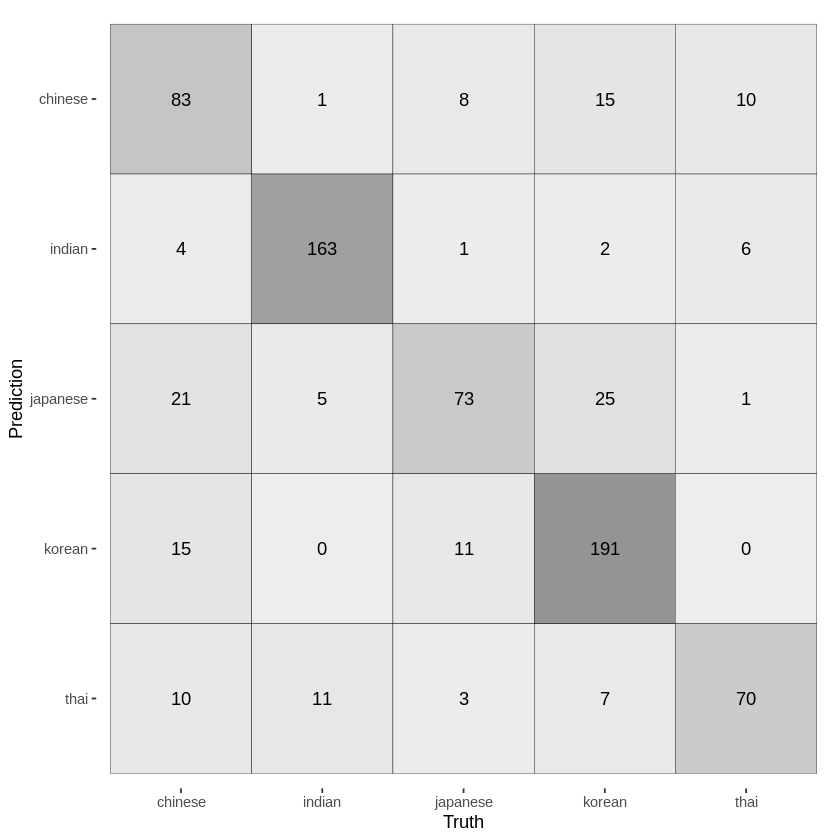

In [11]:
update_geom_defaults(geom = "tile", new = list(color = "black", alpha = 0.7))
# Visualize confusion matrix
results %>% 
  conf_mat(cuisine, .pred_class) %>% 
  autoplot(type = "heatmap")

По-тъмните квадратчета в графиката на матрицата на объркване показват голям брой случаи, и вероятно можете да видите диагонална линия от по-тъмни квадратчета, която показва случаите, при които предсказаните и действителните етикети съвпадат.

Сега нека изчислим обобщените статистики за матрицата на объркване.


In [12]:
# Summary stats for confusion matrix
conf_mat(data = results, truth = cuisine, estimate = .pred_class) %>% 
summary()

.metric              .estimator .estimate
1  accuracy             multiclass 0.7880435
2  kap                  multiclass 0.7276583
3  sens                 macro      0.7780927
4  spec                 macro      0.9477598
5  ppv                  macro      0.7585583
6  npv                  macro      0.9460080
7  mcc                  multiclass 0.7292724
8  j_index              macro      0.7258524
9  bal_accuracy         macro      0.8629262
10 detection_prevalence macro      0.2000000
11 precision            macro      0.7585583
12 recall               macro      0.7780927
13 f_meas               macro      0.7641862

Ако се фокусираме върху някои метрики като точност, чувствителност, положителна предсказваща стойност (PPV), не сме зле за начало 🥳!

## 4. По-задълбочен поглед

Нека зададем един фин въпрос: Какви критерии се използват, за да се избере даден тип кухня като предсказан резултат?

Е, статистическите алгоритми за машинно обучение, като логистичната регресия, се базират на `вероятност`; така че това, което всъщност се предсказва от класификатора, е вероятностно разпределение върху набор от възможни резултати. Класът с най-висока вероятност след това се избира като най-вероятен резултат за дадените наблюдения.

Нека видим това в действие, като направим както твърди класови предсказания, така и вероятности.


In [13]:
# Make hard class prediction and probabilities
results_prob <- cuisines_test %>%
  select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test)) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test, type = "prob"))

# Print out results
results_prob %>% 
  slice_head(n = 5)

cuisine .pred_class .pred_chinese .pred_indian .pred_japanese .pred_korean
1 indian  thai        1.551259e-03  0.4587877    5.988039e-04   2.428503e-04
2 indian  indian      2.637133e-05  0.9999488    6.648651e-07   2.259993e-05
3 indian  indian      1.049433e-03  0.9909982    1.060937e-03   1.644947e-05
4 indian  indian      6.237482e-02  0.4763035    9.136702e-02   3.660913e-01
5 indian  indian      1.431745e-02  0.9418551    2.945239e-02   8.721782e-03
  .pred_thai  
1 5.388194e-01
2 1.577948e-06
3 6.874989e-03
4 3.863391e-03
5 5.653283e-03

Много по-добре!

✅ Можете ли да обясните защо моделът е толкова сигурен, че първото наблюдение е тайландско?

## **🚀Предизвикателство**

В този урок използвахте почистените си данни, за да създадете модел за машинно обучение, който може да предскаже национална кухня въз основа на серия от съставки. Отделете време, за да разгледате [многото опции](https://www.tidymodels.org/find/parsnip/#models), които Tidymodels предоставя за класифициране на данни, и [други начини](https://parsnip.tidymodels.org/articles/articles/Examples.html#multinom_reg-models) за прилагане на мултиномна регресия.

#### БЛАГОДАРНОСТИ КЪМ:

[`Алисън Хорст`](https://twitter.com/allison_horst/) за създаването на невероятните илюстрации, които правят R по-приветлив и ангажиращ. Намерете още илюстрации в нейния [галерия](https://www.google.com/url?q=https://github.com/allisonhorst/stats-illustrations&sa=D&source=editors&ust=1626380772530000&usg=AOvVaw3zcfyCizFQZpkSLzxiiQEM).

[Каси Бревиу](https://www.twitter.com/cassieview) и [Джен Лупър](https://www.twitter.com/jenlooper) за създаването на оригиналната Python версия на този модул ♥️

<br>
Щях да добавя няколко шеги, но не разбирам хранителни каламбури 😅.

<br>

Приятно учене,

[Ерик](https://twitter.com/ericntay), Златен студентски посланик на Microsoft Learn.



---

**Отказ от отговорност**:  
Този документ е преведен с помощта на AI услуга за превод [Co-op Translator](https://github.com/Azure/co-op-translator). Въпреки че се стремим към точност, моля, имайте предвид, че автоматизираните преводи може да съдържат грешки или неточности. Оригиналният документ на неговия изходен език трябва да се счита за авторитетен източник. За критична информация се препоръчва професионален превод от човек. Ние не носим отговорност за каквито и да било недоразумения или погрешни интерпретации, произтичащи от използването на този превод.
